In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from JINAPyCEE import gamma

import caga; reload(caga);

In [3]:
gt = caga.gamma_tree.load("H1725272_LX11/rsid686.npy")
#gt = caga.gamma_tree.load("H1725272_LX11/rsid23.npy")

In [4]:
kw = gt.kwargs

In [5]:
np.log10(gt.m_DM_0)

12.067528837481948

In [6]:
np.log10(gt.Mpeak)

12.067528837481948

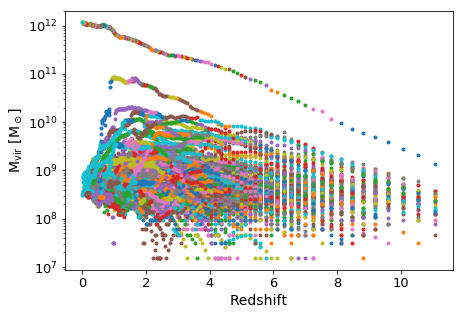

In [7]:
fig = gt.plot_mass_history()

In [8]:
kwargs = caga.generate_kwargs(gt, 1e7)
assert kwargs["pre_calculate_SSPs"]

OMEGA run in progress..
SYGMA run in progress..
   SYGMA run completed - Run time: 0.1s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.06s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.06s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
Warning -- Not enough gas to sustain the SFH. 2
   OMEGA run completed - Run time: 3.84s


In [9]:
# Run GAMMA
kwargs["sfe"] = 0.005
kwargs["print_off"] = True
g = gamma.gamma(**kwargs)

GAMMA run in progress..
   GAMMA run completed - Run time: 41.05s


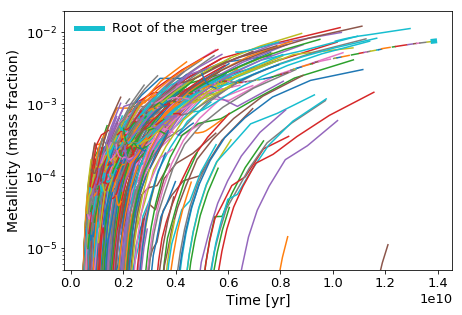

In [10]:
fig = caga.plot.metallicity_evolution(g,tree_trunk_ID=gt.tree_trunk_ID)

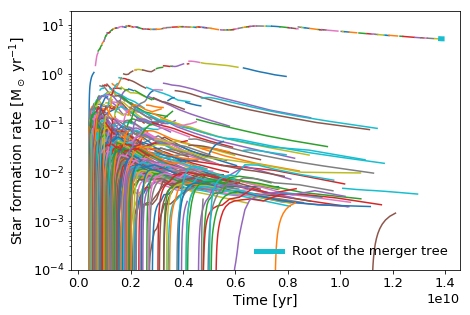

In [11]:
fig = caga.plot.sfh_evolution(g,tree_trunk_ID=gt.tree_trunk_ID)

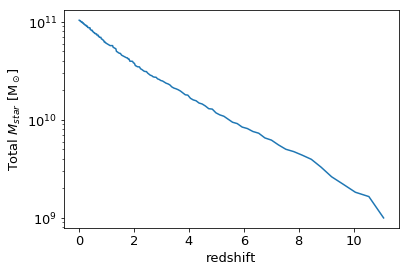

In [12]:
fig = caga.plot.mstar_evolution(g,reduction_factor=0.7)

/Users/alexji/Dropbox/caterpillar/NuPyCEE/caga/caga/caga.py:209: RuntimeWarning: divide by zero encountered in log10
  Fe_H.append( np.log10(m_Fe_H_ratio) - np.log10((10**(7.50-12))*56.0) )


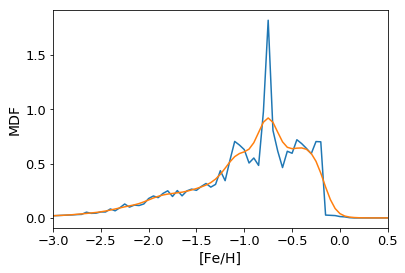

In [13]:
fig, (mdf_x, mdf_y, mdf_gauss_y) = caga.plot.metallicity_distribution(g, sigma_gauss=0.1)